# 1. Introduction
### I'm using data provided by NathanGeorge on all Lending Club (https://www.lendingclub.com/) accepted and declined loan requests from the beginning of 2007 to the end of 2018.  (https://www.kaggle.com/wordsforthewise/lending-club)  

### The ability to grade (or more specifically: predict the outcome of) a given loan is of tantamount interest to a lender as to maximize their ROI (return on investment).  A borrower with a higher risk is typically given a greater interest rate as to minimize loss in the event that they default, while a borrower with lower risk is typically given a lower interest rate as to maximize the chance that they'll choose their financial institution over another while still earning a profit.  

### A machine learning model could predict the likelihood of various outcomes (in particular: default/charge-off or paid off) based on borrower/loan data.  Lenders could better throttle their interest rates, term-length, and whether or not to accept a loan proposal based on these predictions.  How these predictions correlate with the lenders' own loan grades is also of interest, as it is in general a letter grade ranking (Lending Club uses A-G) of how likely a debtor is to pay back a debt.  Were they able to make as accurate of predictions as the machine learning model?

![Image of Grades](https://www.moneycrashers.com/wp-content/uploads/2015/04/reward-risk.png)

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import time

import itertools
from itertools import combinations

import scipy as sp
from scipy.stats import pearsonr, chi2_contingency

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from datetime import datetime
from dateutil import relativedelta

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
from statsmodels.stats.proportion import proportion_confint

# from catboost import Pool, CatBoostClassifier (maybe I'll include this?)

import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from sklearn import linear_model, preprocessing, model_selection, svm, datasets
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.metrics import precision_recall_fscore_support, r2_score, auc, classification_report, roc_curve, roc_auc_score, confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, accuracy_score,log_loss
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler #do we use this?
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


# 2. Importing Data
### A preliminary glance of the CSV data showed that there are millions of loans, though the only ones of interest are the accepted loans that were 'Fully Paid', 'Charged Off'' in the 'loan_status' column.  To save some time, the unique 'id' column was set to the index.  According to Lending Club:

"In general, a note goes into Default status when it is 121 or more days past due.  When a note is in Default status, Charge Off occurs no later than 150 days past due (i.e. No later than 30 days after the Default status is reached) when there is no reasonable expectation of sufficient payment to prevent the charge off.  However, bankruptcies may be charged off earlier based on date of bankruptcy notification."

In [2]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv', index_col='id') 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [4]:
df.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68407277,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68355089,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,

In [5]:
df.tail()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89905081,NaN,18000.0,18000.0,18000.0,60 months,9.49,377.95,B,B2,NaN,5 years,OWN,130000.0,Not Verified,Oct-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=89905081,NaN,home_improvement,Home improvement,775xx,TX,20.59,0.0,Jul-2004,735.0,739.0,1.0,NaN,NaN,17.0,0.0,23833.0,34.0,39.0,f,0.0,0.0,20756.233632,20756.23,18000.00,2756.23,0.0,0.0,0.0,Aug-2018,12828.77,NaN,Mar-2019,709.0,705.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,168758.0,0.0,6.0,0.0,3.0,15.0,30516.0,52.0,0.0,3.0,7061.0,41.0,70100.0,1.0,2.0,1.0,6.0,9927.0,4161.0,68.2,0.0,0.0,113.0,146.0,17.0,15.0,3.0,17.0,NaN,2.0,NaN,0.0,3.0,9.0,3.0,5.0,21.0,10.0,15.0,9.0,17.0,0.0,0.0,0.0,0.0,100.0,33.3,0.0,0.0,275356.0,54349.0,13100.0,77756.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
88948836,NaN,29400.0,29400.0,29400.0,60 months,13.99,683.94,C,C3,Chief Operating Officer,9 years,MORTGAGE,180792.0,Not Verified,Oct-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=88948836,NaN,debt_consolidation,Debt consolidation,900xx,CA,22.03,0.0,Mar-2002,705.0,709.0,1.0,NaN,NaN,16.0,0.0,77480.0,85.2,32.0,f,0.0,0.0,35848.764532,35848.76,29400.00,6448.76,0.0,0.0,0.0,Jul-2018,22192.81,NaN,Jul-2018,719.0,715.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,663465.0,0.0,4.0,2.0,4.0,8.0,70652.0,50.0,0.0,0.0,31069.0,68.0,86500.0,3.0,0.0,

### How many rows and 151 columns.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345310 entries, 68407277 to 88224441
Columns: 150 entries, member_id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.5+ GB


### Though it's no longer on Kaggle, Wendy Kan provided a list of column names and descriptions to aid in culling our columns. 

In [7]:
# acc_now_delinq	The number of accounts on which the borrower is now delinquent.
# acc_open_past_24mths	Number of trades opened in past 24 months.
# addr_state	The state provided by the borrower in the loan application
# all_util	Balance to credit limit on all trades
# annual_inc	The self-reported annual income provided by the borrower during registration.
# annual_inc_joint	The combined self-reported annual income provided by the co-borrowers during registration
# application_type	Indicates whether the loan is an individual application or a joint application with two co-borrowers
# avg_cur_bal	Average current balance of all accounts
# bc_open_to_buy	Total open to buy on revolving bankcards.
# bc_util	Ratio of total current balance to high credit/credit limit for all bankcard accounts.
# chargeoff_within_12_mths	Number of charge-offs within 12 months
# collection_recovery_fee	post charge off collection fee
# collections_12_mths_ex_med	Number of collections in 12 months excluding medical collections
# debt_settlement_flag	Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.
# debt_settlement_flag_date	The most recent date that the Debt_Settlement_Flag has been set  
# deferral_term	Amount of months that the borrower is expected to pay less than the contractual monthly payment amount due to a hardship plan
# delinq_2yrs	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
# delinq_amnt	The past-due amount owed for the accounts on which the borrower is now delinquent.
# desc	Loan description provided by the borrower
# disbursement_method	The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY
# dti	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
# dti_joint	A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income
# earliest_cr_line	The month the borrower's earliest reported credit line was opened
# emp_length	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
# emp_title	The job title supplied by the Borrower when applying for the loan.*
# fico_range_high	The upper boundary range the borrower’s FICO at loan origination belongs to.
# fico_range_low	The lower boundary range the borrower’s FICO at loan origination belongs to.
# funded_amnt	The total amount committed to that loan at that point in time.
# funded_amnt_inv	The total amount committed by investors for that loan at that point in time.
# grade	LC assigned loan grade
# hardship_amount	The interest payment that the borrower has committed to make each month while they are on a hardship plan
# hardship_dpd	Account days past due as of the hardship plan start date
# hardship_end_date	The end date of the hardship plan period
# hardship_flag	Flags whether or not the borrower is on a hardship plan
# hardship_last_payment_amount	The last payment amount as of the hardship plan start date
# hardship_length	The number of months the borrower will make smaller payments than normally obligated due to a hardship plan
# hardship_loan_status	Loan Status as of the hardship plan start date
# hardship_payoff_balance_amount	The payoff balance amount as of the hardship plan start date
# hardship_reason	Describes the reason the hardship plan was offered
# hardship_start_date	The start date of the hardship plan period
# hardship_status	Describes if the hardship plan is active, pending, canceled, completed, or broken
# hardship_type	Describes the hardship plan offering
# home_ownership	The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
# id	A unique LC assigned ID for the loan listing.
# il_util	Ratio of total current balance to high credit/credit limit on all install acct
# initial_list_status	The initial listing status of the loan. Possible values are – W, F
# inq_fi	Number of personal finance inquiries
# inq_last_12m	Number of credit inquiries in past 12 months
# inq_last_6mths	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
# installment	The monthly payment owed by the borrower if the loan originates.
# int_rate	Interest Rate on the loan
# issue_d	The month which the loan was funded
# last_credit_pull_d	The most recent month LC pulled credit for this loan
# last_fico_range_high	The upper boundary range the borrower’s last FICO pulled belongs to.
# last_fico_range_low	The lower boundary range the borrower’s last FICO pulled belongs to.
# last_pymnt_amnt	Last total payment amount received
# last_pymnt_d	Last month payment was received
# loan_amnt	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
# loan_status	Current status of the loan
# max_bal_bc	Maximum current balance owed on all revolving accounts
# member_id	A unique LC assigned Id for the borrower member.
# mo_sin_old_il_acct	Months since oldest bank installment account opened
# mo_sin_old_rev_tl_op	Months since oldest revolving account opened
# mo_sin_rcnt_rev_tl_op	Months since most recent revolving account opened
# mo_sin_rcnt_tl	Months since most recent account opened
# mort_acc	Number of mortgage accounts.
# mths_since_last_delinq	The number of months since the borrower's last delinquency.
# mths_since_last_major_derog	Months since most recent 90-day or worse rating
# mths_since_last_record	The number of months since the last public record.
# mths_since_rcnt_il	Months since most recent installment accounts opened
# mths_since_recent_bc	Months since most recent bankcard account opened.
# mths_since_recent_bc_dlq	Months since most recent bankcard delinquency
# mths_since_recent_inq	Months since most recent inquiry.
# mths_since_recent_revol_delinq	Months since most recent revolving delinquency.
# next_pymnt_d	Next scheduled payment date
# num_accts_ever_120_pd	Number of accounts ever 120 or more days past due
# num_actv_bc_tl	Number of currently active bankcard accounts
# num_actv_rev_tl	Number of currently active revolving trades
# num_bc_sats	Number of satisfactory bankcard accounts
# num_bc_tl	Number of bankcard accounts
# num_il_tl	Number of installment accounts
# num_op_rev_tl	Number of open revolving accounts
# num_rev_accts	Number of revolving accounts
# num_rev_tl_bal_gt_0	Number of revolving trades with balance >0
# num_sats	Number of satisfactory accounts
# num_tl_120dpd_2m	Number of accounts currently 120 days past due (updated in past 2 months)
# num_tl_30dpd	Number of accounts currently 30 days past due (updated in past 2 months)
# num_tl_90g_dpd_24m	Number of accounts 90 or more days past due in last 24 months
# num_tl_op_past_12m	Number of accounts opened in past 12 months
# open_acc	The number of open credit lines in the borrower's credit file.
# open_acc_6m	Number of open trades in last 6 months
# open_act_il	Number of currently active installment trades
# open_il_12m	Number of installment accounts opened in past 12 months
# open_il_24m	Number of installment accounts opened in past 24 months
# open_rv_12m	Number of revolving trades opened in past 12 months
# open_rv_24m	Number of revolving trades opened in past 24 months
# orig_projected_additional_accrued_interest	The original projected additional interest amount that will accrue for the given hardship payment plan as of the Hardship Start Date. This field will be null if the borrower has broken their hardship payment plan.
# out_prncp	Remaining outstanding principal for total amount funded
# out_prncp_inv	Remaining outstanding principal for portion of total amount funded by investors
# payment_plan_start_date	The day the first hardship plan payment is due. For example, if a borrower has a hardship plan period of 3 months, the start date is the start of the three-month period in which the borrower is allowed to make interest-only payments.
# pct_tl_nvr_dlq	Percent of trades never delinquent
# percent_bc_gt_75	Percentage of all bankcard accounts > 75% of limit.
# policy_code	"publicly available policy_code=1
# new products not publicly available policy_code=2"
# pub_rec	Number of derogatory public records
# pub_rec_bankruptcies	Number of public record bankruptcies
# purpose	A category provided by the borrower for the loan request. 
# pymnt_plan	Indicates if a payment plan has been put in place for the loan
# recoveries	post charge off gross recovery
# revol_bal	Total credit revolving balance
# revol_bal_joint 	 Sum of revolving credit balance of the co-borrowers, net of duplicate balances
# revol_util	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
# sec_app_chargeoff_within_12_mths 	 Number of charge-offs within last 12 months at time of application for the secondary applicant
# sec_app_collections_12_mths_ex_med 	 Number of collections within last 12 months excluding medical collections at time of application for the secondary applicant
# sec_app_earliest_cr_line 	 Earliest credit line at time of application for the secondary applicant
# sec_app_fico_range_high 	 FICO range (low) for the secondary applicant
# sec_app_fico_range_low 	 FICO range (high) for the secondary applicant
# sec_app_inq_last_6mths 	 Credit inquiries in the last 6 months at time of application for the secondary applicant
# sec_app_mort_acc 	 Number of mortgage accounts at time of application for the secondary applicant
# sec_app_mths_since_last_major_derog 	 Months since most recent 90-day or worse rating at time of application for the secondary applicant
# sec_app_num_rev_accts 	 Number of revolving accounts at time of application for the secondary applicant
# sec_app_open_acc 	 Number of open trades at time of application for the secondary applicant
# sec_app_open_act_il	 Number of currently active installment trades at time of application for the secondary applicant
# sec_app_revol_util 	 Ratio of total current balance to high credit/credit limit for all revolving accounts
# settlement_amount	The loan amount that the borrower has agreed to settle for
# settlement_date	The date that the borrower agrees to the settlement plan
# settlement_percentage	The settlement amount as a percentage of the payoff balance amount on the loan
# settlement_status	The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT
# settlement_term	The number of months that the borrower will be on the settlement plan
# sub_grade	LC assigned loan subgrade
# tax_liens	Number of tax liens
# term	The number of payments on the loan. Values are in months and can be either 36 or 60.
# title	The loan title provided by the borrower
# tot_coll_amt	Total collection amounts ever owed
# tot_cur_bal	Total current balance of all accounts
# tot_hi_cred_lim	Total high credit/credit limit
# total_acc	The total number of credit lines currently in the borrower's credit file
# total_bal_ex_mort	Total credit balance excluding mortgage
# total_bal_il	Total current balance of all installment accounts
# total_bc_limit	Total bankcard high credit/credit limit
# total_cu_tl	Number of finance trades
# total_il_high_credit_limit	Total installment high credit/credit limit
# total_pymnt	Payments received to date for total amount funded
# total_pymnt_inv	Payments received to date for portion of total amount funded by investors
# total_rec_int	Interest received to date
# total_rec_late_fee	Late fees received to date
# total_rec_prncp	Principal received to date
# total_rev_hi_lim  	Total revolving high credit/credit limit
# url	URL for the LC page with listing data.
# verification_status	Indicates if income was verified by LC, not verified, or if the income source was verified
# verified_status_joint	Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
# zip_code	The first 3 numbers of the zip code provided by the borrower in the loan application.

# 	* Employer Title replaces Employer Name for all loans listed after 9/23/2013


### There are a variety of data types:

In [8]:
df.dtypes

member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                                            object
desc                        

# 3. Data Cleaning

### Some columns have NO null values and a few have ONLY null values:

In [9]:
df.isnull().sum().sort_values()

hardship_flag                                       0
fico_range_high                                     0
disbursement_method                                 0
open_acc                                            0
pub_rec                                             0
revol_bal                                           0
total_acc                                           0
initial_list_status                                 0
out_prncp                                           0
out_prncp_inv                                       0
earliest_cr_line                                    0
total_pymnt                                         0
total_rec_prncp                                     0
total_rec_int                                       0
total_rec_late_fee                                  0
recoveries                                          0
collection_recovery_fee                             0
last_pymnt_amnt                                     0
application_type            

In [10]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
member_id,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,1.34531e+06,NaN,NaN,NaN,14420,8717.05,500,8000,12000,20000,40000
funded_amnt,1.34531e+06,NaN,NaN,NaN,14411.6,8713.12,500,8000,12000,20000,40000
funded_amnt_inv,1.34531e+06,NaN,NaN,NaN,14389.1,8715.49,0,7875,12000,20000,40000
term,1345310,2,36 months,1020743,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,1.34531e+06,NaN,NaN,NaN,13.2396,4.76872,5.31,9.75,12.74,15.99,30.99
installment,1.34531e+06,NaN,NaN,NaN,438.076,261.513,4.93,248.48,375.43,580.73,1719.83
grade,1345310,7,B,392741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,1345310,35,C1,85494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,1259525,378353,Teacher,21268,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Let's start by dropping those with ONLY null values:

In [11]:
df.drop(['member_id','desc','hardship_type','hardship_reason','hardship_status','deferral_term','hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date','hardship_length','hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest','hardship_payoff_balance_amount','hardship_last_payment_amount','debt_settlement_flag_date','settlement_status','settlement_date','settlement_amount','settlement_percentage','settlement_term'], axis=1,inplace=True)

### I'll drop these rows for loans with two joint applicants for simplicity in drawing conclusions.

In [12]:
df = df[df['application_type']!='Joint App']
df.drop(['revol_bal_joint','dti_joint','verification_status_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog','annual_inc_joint','application_type'],axis=1,inplace=True)

### I'll drop 'funded_amnt' and 'funded_amnt_inv' since they're essentially the same as 'loan_amnt'.

In [13]:
df.drop(['funded_amnt','funded_amnt_inv'], axis=1,inplace=True)

### 'emp_length' is potential useful, but it has characters like '<' and '+' and 'year(s)'.  We'll have to approximate.

In [14]:
df['emp_length'].value_counts()

10+ years    435633
2 years      119867
3 years      106015
< 1 year     102544
1 year        87271
5 years       82927
4 years       79311
6 years       61920
8 years       60004
7 years       58919
9 years       50335
Name: emp_length, dtype: int64

In [15]:
df['emp_length']=df['emp_length'].str.replace('< 1 year','0')
df['emp_length']=pd.to_numeric(df['emp_length'].str.replace('\D',''))

### 'term' is a string that tells how many months the loan's term was for, so we can convert it to numeric

In [16]:
df['term'].value_counts()

 36 months    1004477
 60 months     315033
Name: term, dtype: int64

In [17]:
df['term']=pd.to_numeric(df['term'].str.replace('\D',''))

### 'earliest_cr_line' is the month and year of opening their first line of credit.  'issue_d' is the date the loand was issued.  I'll find out the length of time between those.

In [18]:
df['issue_d'] = pd.to_datetime(df['issue_d'],format="%b-%Y")
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'],format="%b-%Y")
df['earliest_to_loan_issue'] = ((df['issue_d'] - df['earliest_cr_line']).dt.days/365.25)

### Dropping less relevant variables such as recently acquired data as it wouldn't serve in our PREDICTION model: 'url', 'zip_code', 'addr_state', 'initial_list_status','last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util', 'mths_since_rcnt_il', 'il_util', 'all_util', 'avg_cur_bal', 'bc_open_to_buy', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'bc_util', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'emp_title', 'mths_since_recent_inq', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'policy_code', 'acc_now_delinq','open_acc_6m','open_rv_12m', 'open_rv_24m', 'acc_open_past_24mths', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'tot_cur_bal', 'total_bal_il', 'max_bal_bc', 'open_act_il', 'open_il_12m', 'inq_last_6mths',  'num_tl_120dpd_2m', 'num_tl_30dpd', 'inq_fi', 'total_cu_tl'

In [19]:
df.drop((['url', 'zip_code', 'addr_state','initial_list_status','last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util','mths_since_rcnt_il', 'il_util', 'all_util', 'avg_cur_bal', 'bc_open_to_buy', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low','bc_util','pct_tl_nvr_dlq','percent_bc_gt_75','emp_title','mths_since_recent_inq','pymnt_plan','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','policy_code','acc_now_delinq','open_acc_6m','open_rv_12m', 'open_rv_24m','acc_open_past_24mths', 'num_actv_rev_tl','num_rev_tl_bal_gt_0','tot_cur_bal','total_bal_il', 'max_bal_bc', 'open_act_il', 'open_il_12m', 'inq_last_6mths',  'num_tl_120dpd_2m', 'num_tl_30dpd', 'inq_fi', 'total_cu_tl']), axis=1,inplace=True)

### We'll adhere to the more general 'grade' as opposed to the more specific 'sub_grade' and create dummies.  We'll do the same for some of these other potentially important columns.

In [20]:
df['grade'].value_counts()

B    386373
C    373401
A    231630
D    196278
E     91664
F     31351
G      8813
Name: grade, dtype: int64

In [21]:
df.drop(['sub_grade'], axis=1, inplace=True)

### 'purpose' is the reason for applying for a loan, and we'll drop its duplicate 'title'.

In [22]:
df['purpose'].value_counts()

debt_consolidation    764351
credit_card           290840
home_improvement       85456
other                  76429
major_purchase         28931
small_business         15180
medical                15097
car                    14380
moving                  9289
vacation                8934
house                   7085
wedding                 2294
renewable_energy         918
educational              326
Name: purpose, dtype: int64

In [23]:
df.drop('title', axis=1,inplace=True)

In [24]:
df['home_ownership'].value_counts()

MORTGAGE    648107
RENT        528509
OWN         142418
ANY            286
OTHER          144
NONE            46
Name: home_ownership, dtype: int64

In [25]:
df['verification_status'].value_counts()

Source Verified    513873
Verified           408334
Not Verified       397303
Name: verification_status, dtype: int64

In [26]:
df['loan_status'].value_counts()

Fully Paid     1057295
Charged Off     262215
Name: loan_status, dtype: int64

In [27]:
# df = pd.get_dummies(data=df, columns=['grade','purpose','home_ownership','verification_status','loan_status'], prefix=['gra','pur','hom_own','ver_sta','loa_sta'], dtype=int)

### That takes care of all of our non-numeric columns.

In [28]:
df.select_dtypes(exclude=('float64','int32','int64','datetime64[ns]')).columns

Index(['grade', 'home_ownership', 'verification_status', 'loan_status',
       'purpose'],
      dtype='object')

In [29]:
df.select_dtypes(include=('float64')).columns

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'tot_coll_amt', 'open_il_24m',
       'total_rev_hi_lim', 'inq_last_12m', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'earliest_to_loan_issue'],
      dtype='object')

In [30]:
df.select_dtypes(include=('int32','int64')).columns

Index(['term'], dtype='object')

In [31]:
df.select_dtypes(include=('datetime64[ns]')).columns

Index(['issue_d', 'earliest_cr_line'], dtype='object')

### Time to do something about the null values remaining

In [32]:
df[df.columns[df.isnull().any()]].isnull().sum().sort_values()

tax_liens                              39
collections_12_mths_ex_med             56
chargeoff_within_12_mths               56
pub_rec_bankruptcies                  697
mort_acc                            47281
total_bal_ex_mort                   47281
total_bc_limit                      47281
num_bc_sats                         55841
num_sats                            55841
mths_since_recent_bc                59633
num_op_rev_tl                       67527
num_il_tl                           67527
num_bc_tl                           67527
num_actv_bc_tl                      67527
num_accts_ever_120_pd               67527
total_il_high_credit_limit          67527
mo_sin_rcnt_tl                      67527
total_rev_hi_lim                    67527
tot_hi_cred_lim                     67527
tot_coll_amt                        67527
num_tl_op_past_12m                  67527
num_tl_90g_dpd_24m                  67527
mo_sin_rcnt_rev_tl_op               67528
mo_sin_old_rev_tl_op              

In [33]:
(100*df[df.columns[df.isnull().any()]].isnull().sum()/len(df.index)).sort_values()

tax_liens                          0.002956
collections_12_mths_ex_med         0.004244
chargeoff_within_12_mths           0.004244
pub_rec_bankruptcies               0.052823
mort_acc                           3.583224
total_bal_ex_mort                  3.583224
total_bc_limit                     3.583224
num_bc_sats                        4.231950
num_sats                           4.231950
mths_since_recent_bc               4.519329
num_op_rev_tl                      5.117582
num_il_tl                          5.117582
num_bc_tl                          5.117582
num_actv_bc_tl                     5.117582
num_accts_ever_120_pd              5.117582
total_il_high_credit_limit         5.117582
mo_sin_rcnt_tl                     5.117582
total_rev_hi_lim                   5.117582
tot_hi_cred_lim                    5.117582
tot_coll_amt                       5.117582
num_tl_op_past_12m                 5.117582
num_tl_90g_dpd_24m                 5.117582
mo_sin_rcnt_rev_tl_op           

### So there are a set of rows that are all missing data in the same columns.  I'd like to keep those columns, so I'll just drop those rows.

In [34]:
df.dropna(subset=['tot_coll_amt'], inplace=True)
df[df.columns[df.isnull().any()]].isnull().sum().sort_values()

mo_sin_old_rev_tl_op                   1
mo_sin_rcnt_rev_tl_op                  1
num_rev_accts                          1
mths_since_recent_bc               12113
mo_sin_old_il_acct                 37287
emp_length                         72737
open_il_24m                       739910
inq_last_12m                      739911
mths_since_recent_revol_delinq    815217
mths_since_last_major_derog       904375
mths_since_recent_bc_dlq          938512
dtype: int64

In [35]:
(100*df[df.columns[df.isnull().any()]].isnull().sum()/len(df.index)).sort_values()

mo_sin_old_rev_tl_op               0.000080
mo_sin_rcnt_rev_tl_op              0.000080
num_rev_accts                      0.000080
mths_since_recent_bc               0.967505
mo_sin_old_il_acct                 2.978235
emp_length                         5.809743
open_il_24m                       59.099045
inq_last_12m                      59.099125
mths_since_recent_revol_delinq    65.114063
mths_since_last_major_derog       72.235406
mths_since_recent_bc_dlq          74.962040
dtype: float64

### There's no way to interpret null values in 'emp_length', 'mths_since_recent_bc', 'mo_sin_old_il_acct ', so we'll fill with the median.

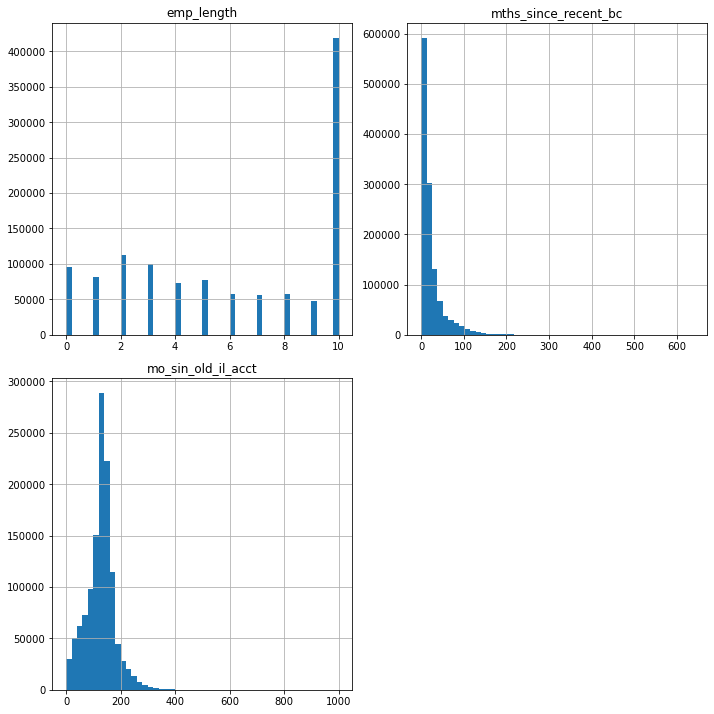

In [36]:
plt.subplot(2,2,1)
df['emp_length'].hist(figsize=(10, 10), bins=50)
plt.title('emp_length')

plt.subplot(2,2,2)
df['mths_since_recent_bc'].hist(figsize=(10, 10), bins=50)
plt.title('mths_since_recent_bc')

plt.subplot(2,2,3)
df['mo_sin_old_il_acct'].hist(figsize=(10, 10), bins=50)
plt.title('mo_sin_old_il_acct')

plt.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain')
plt.tight_layout(pad=1)
plt.show()

In [37]:
df['emp_length'].fillna(df['emp_length'].median(),inplace=True)
df['mths_since_recent_bc'].fillna(df['mths_since_recent_bc'].median(),inplace=True)
df['mo_sin_old_il_acct'].fillna(df['mo_sin_old_il_acct'].median(),inplace=True)

### We'll drop these rows that are missing only 1 value.

In [38]:
df.dropna(subset=['mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts'], inplace=True)

### 'open_il_24m',  'inq_last_12m' measure things that could very easily not happen within a short time frame.  It will be filled with 0s.

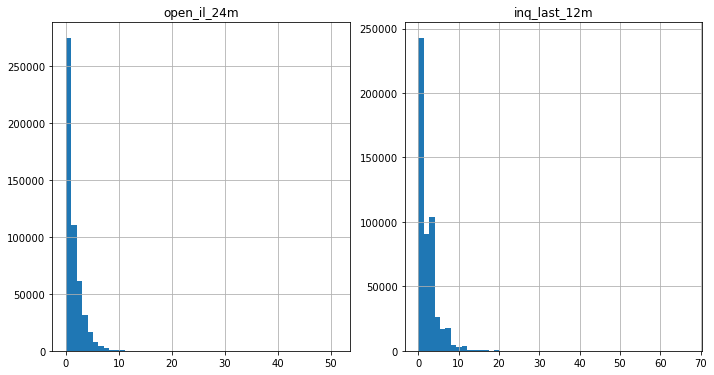

In [39]:
plt.subplot(2,2,1)
df['open_il_24m'].hist(figsize=(10, 10), bins=50)
plt.title('open_il_24m')

plt.subplot(2,2,2)
df['inq_last_12m'].hist(figsize=(10, 10), bins=50)
plt.title('inq_last_12m')

plt.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain')
plt.tight_layout(pad=1)
plt.show()

In [40]:
df['open_il_24m'].fillna(value=0, inplace=True)
df['inq_last_12m'].fillna(value=0, inplace=True)

### 'mths_since_last_major_derog' and 'mths_since_recent_bc_dlq' and 'mths_since_recent_revol_delinq' will be filled with the max value since they measure when the last occurence of a bad credit event happened, and it's quite possible that these events have never happened, and it seems unlikely that these negative events wouldn't be recorded. 

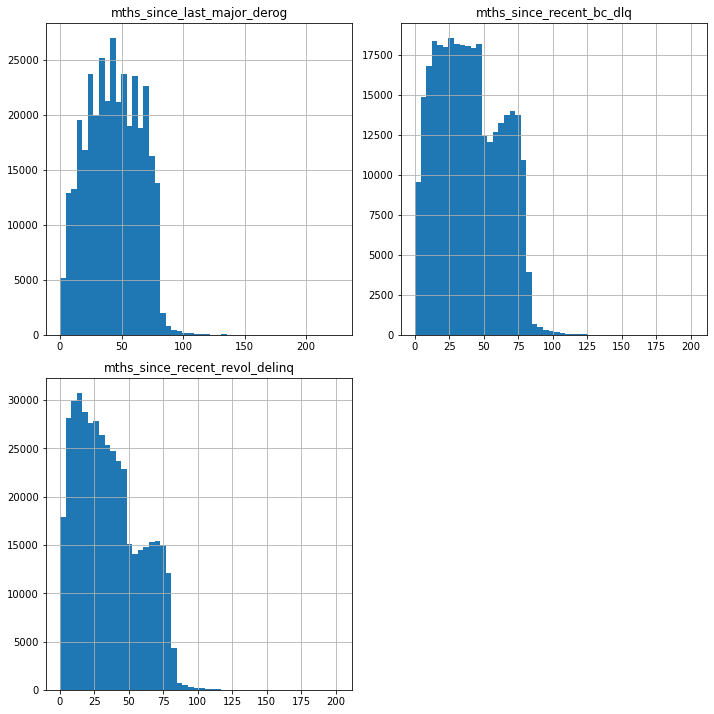

In [41]:
plt.subplot(2,2,1)
df['mths_since_last_major_derog'].hist(figsize=(10, 10), bins=50)
plt.title('mths_since_last_major_derog')

plt.subplot(2,2,2)
df['mths_since_recent_bc_dlq'].hist(figsize=(10, 10), bins=50)
plt.title('mths_since_recent_bc_dlq')

plt.subplot(2,2,3)
df['mths_since_recent_revol_delinq'].hist(figsize=(10, 10), bins=50)
plt.title('mths_since_recent_revol_delinq')

plt.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain')
plt.tight_layout(pad=1)
plt.show()

In [42]:
df['mths_since_last_major_derog'].fillna(df['mths_since_last_major_derog'].max(),inplace=True)
df['mths_since_recent_bc_dlq'].fillna(df['mths_since_recent_bc_dlq'].max(),inplace=True)
df['mths_since_recent_revol_delinq'].fillna(df['mths_since_recent_revol_delinq'].max(),inplace=True)

### No null values left:

In [43]:
df[df.columns[df.isnull().any()]].isnull().sum().sort_values()

Series([], dtype: float64)

In [44]:
df = pd.get_dummies(data=df, columns=['grade','purpose','home_ownership','verification_status'], prefix=['gra','pur','hom_own','ver_sta'], dtype=int)
df_all_dummies = df
df_all_dummies = pd.get_dummies(data=df_all_dummies, columns=['loan_status'], prefix=['loan_status'], dtype=int)


### So this is what my data looks like now.  Still have 1.3M rows and 81 columns (33 of those are the dummies).

In [45]:
df_all_dummies.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
loan_amnt,1.25198e+06,NaN,NaT,NaN,NaT,NaT,14453.5,8686.28,1000,8000,12000,20000,40000
term,1.25198e+06,NaN,NaT,NaN,NaT,NaT,41.7346,10.2345,36,36,36,36,60
int_rate,1.25198e+06,NaN,NaT,NaN,NaT,NaT,13.2507,4.77629,5.31,9.75,12.74,16.01,30.99
installment,1.25198e+06,NaN,NaT,NaN,NaT,NaT,439.631,260.775,4.93,250.55,375.99,582.1,1719.83
emp_length,1.25198e+06,NaN,NaT,NaN,NaT,NaT,6.02536,3.57427,0,3,6,10,10
annual_inc,1.25198e+06,NaN,NaT,NaN,NaT,NaT,77032.5,70999.5,2000,46592,65000,92000,1.09992e+07
issue_d,1251981,77,2016-03-01,47858,2012-08-01,2018-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,1.25198e+06,NaN,NaT,NaN,NaT,NaT,18.2132,8.38906,-1,11.92,17.72,24.17,49.96
delinq_2yrs,1.25198e+06,NaN,NaT,NaN,NaT,NaT,0.327389,0.89301,0,0,0,0,39
earliest_cr_line,1251981,735,2001-08-01,8877,1934-04-01,2015-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df_all_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1251981 entries, 68407277 to 88224441
Data columns (total 81 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   loan_amnt                       1251981 non-null  float64       
 1   term                            1251981 non-null  int64         
 2   int_rate                        1251981 non-null  float64       
 3   installment                     1251981 non-null  float64       
 4   emp_length                      1251981 non-null  float64       
 5   annual_inc                      1251981 non-null  float64       
 6   issue_d                         1251981 non-null  datetime64[ns]
 7   dti                             1251981 non-null  float64       
 8   delinq_2yrs                     1251981 non-null  float64       
 9   earliest_cr_line                1251981 non-null  datetime64[ns]
 10  fico_range_low                  1251981

In [47]:
df_all_dummies.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,tot_coll_amt,open_il_24m,total_rev_hi_lim,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,earliest_to_loan_issue,gra_A,gra_B,gra_C,gra_D,gra_E,gra_F,gra_G,pur_car,pur_credit_card,pur_debt_consolidation,pur_educational,pur_home_improvement,pur_house,pur_major_purchase,pur_medical,pur_moving,pur_other,pur_renewable_energy,pur_small_business,pur_vacation,pur_wedding,hom_own_ANY,hom_own_MORTGAGE,hom_own_NONE,hom_own_OTHER,hom_own_OWN,hom_own_RENT,ver_sta_Not Verified,ver_sta_Source Verified,ver_sta_Verified,loan_status_Charged Off,loan_status_Fully Paid
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,36,13.99,123.03,10.0,55000.0,2015-12-01,5.91,0.0,2003-08-01,675.0,679.0,7.0,0.0,2765.0,13.0,0.0,30.0,722.0,1.0,9300.0,4.0,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,69.0,2.0,2.0,2.0,5.0,3.0,4.0,9.0,7.0,0.0,3.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,12.334018,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
68355089,24700.0,36,11.99,820.28,10.0,65000.0,2015-12-01,16.06,1.0,1999-12-01,715.0,719.0,22.0,0.0,21470.0,38.0,0.0,226.0,0.0,1.0,111800.0,6.0,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,202.0,6.0,0.0,5.0,13.0,17.0,6.0,20.0,27.0,22.0,0.0,2.0,0.0,0.0,314017.0,39475.0,79300.0,24667.0,16.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
68476807,10400.0,60,22.45,289.91,3.0,104433.0,2015-12-01,25.37,1.0,1998-06-01,695.0,699.0,12.0,0.0,21929.0,35.0,0.0,226.0,0.0,3.0,34000.0,3.0,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,12.0,0.0,4.0,5.0,9.0,10.0,7.0,19.0,12.0,0.0,4.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,17.500342,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
68426831,11950.0,36,13.44,405.18,4.0,34000.0,2015-12-01,10.20,0.0,1987-10-01,690.0,694.0,5.0,0.0,8822.0,6.0,0.0,226.0,0.0,0.0,12900.0,0.0,0.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,202.0,202.0,0.0,2.0,2.0,2.0,2.0,4.0,4.0,5.0,0.0,0.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,28.167009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
68476668,20000.0,36,9.17,637.58,10.0,180000.0,2015-12-01,14.67,0.0,1990-06-01,680.0,684.0,12.0,0.0,87329.0,27.0,0.0,226.0,0.0,2.0,94200.0,1.0,0.0,0.0,142.0,306.0,10.0,10.0,4.0,12.0,202.0,202.0,0.0,4.0,4.0,5.0,7.0,9.0,16.0,12.0,0.0,2.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,25.500342,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


In [48]:
df_all_dummies.tail()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,tot_coll_amt,open_il_24m,total_rev_hi_lim,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,earliest_to_loan_issue,gra_A,gra_B,gra_C,gra_D,gra_E,gra_F,gra_G,pur_car,pur_credit_card,pur_debt_consolidation,pur_educational,pur_home_improvement,pur_house,pur_major_purchase,pur_medical,pur_moving,pur_other,pur_renewable_energy,pur_small_business,pur_vacation,pur_wedding,hom_own_ANY,hom_own_MORTGAGE,hom_own_NONE,hom_own_OTHER,hom_own_OWN,hom_own_RENT,ver_sta_Not Verified,ver_sta_Source Verified,ver_sta_Verified,loan_status_Charged Off,loan_status_Fully Paid
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89905081,18000.0,60,9.49,377.95,5.0,130000.0,2016-10-01,20.59,0.0,2004-07-01,735.0,739.0,17.0,0.0,23833.0,39.0,0.0,226.0,0.0,3.0,70100.0,1.0,0.0,0.0,113.0,146.0,17.0,15.0,3.0,17.0,202.0,202.0,0.0,3.0,3.0,5.0,21.0,10.0,15.0,17.0,0.0,0.0,0.0,0.0,275356.0,54349.0,13100.0,77756.0,12.251882,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
88948836,29400.0,60,13.99,683.94,9.0,180792.0,2016-10-01,22.03,0.0,2002-03-01,705.0,709.0,16.0,0.0,77480.0,32.0,0.0,226.0,0.0,4.0,86500.0,2.0,0.0,0.0,145.0,174.0,31.0,8.0,3.0,70.0,202.0,202.0,0.0,4.0,7.0,9.0,17.0,8.0,10.0,16.0,0.0,2.0,0.0,0.0,719056.0,148305.0,56500.0,95702.0,14.587269,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
89996426,32000.0,60,14.49,752.74,3.0,157000.0,2016-10-01,10.34,0.0,2011-06-01,735.0,739.0,14.0,0.0,111598.0,18.0,0.0,226.0,0.0,2.0,207500.0,0.0,0.0,0.0,53.0,63.0,4.0,4.0,3.0,4.0,202.0,202.0,0.0,5.0,7.0,7.0,4.0,11.0,11.0,14.0,0.0,2.0,0.0,0.0,524379.0,122872.0,15800.0,23879.0,5.336071,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
90006534,16000.0,60,12.79,362.34,10.0,150000.0,2016-10-01,12.25,0.0,1997-08-01,665.0,669.0,12.0,4.0,7700.0,28.0,0.0,68.0,0.0,6.0,14000.0,1.0,0.0,0.0,147.0,229.0,17.0,4.0,0.0,17.0,202.0,202.0,1.0,3.0,4.0,5.0,15.0,6.0,11.0,12.0,0.0,2.0,3.0,0.0,87473.0,65797.0,10100.0,73473.0,19.167693,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
88224441,24000.0,60,14.49,564.56,6.0,110000.0,2016-10-01,18.30,0.0,1999-07-01,660.0,664.0,10.0,1.0,17641.0,31.0,0.0,67.0,0.0,2.0,25900.0,1.0,0.0,0.0,132.0,206.0,9.0,9.0,2.0,9.0,202.0,202.0,1.0,5.0,5.0,15.0,4.0,8.0,24.0,10.0,0.0,1.0,1.0,0.0,84664.0,62426.0,20700.0,58764.0,17.253936,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0


# 4. Analysis

### So the highest correlations to a loan being charged off are:

    #### int_rate                          0.260420 (the interest rate)
    #### term                              0.178808 (the number of months for the loan to be paid back)
    #### gra_E                             0.128725 (the grades of the loans at time of borrowing)
    #### gra_D                             0.110515
    #### dti                               0.109007 (the debt to income ratio)
    #### gra_F                             0.099753
    #### num_tl_op_past_12m                0.087044 (the number of accounts opened in past 12 months)
    #### hom_own_RENT                      0.069439 (the fact that they rent their home)
    #### ver_sta_Verified                  0.066327 (the fact that they're income was verified)
    #### loan_amnt                         0.064357 (the dollar amount of the loan)
    
    Most of these make sense.  Something that's interesting is that grades F and G didn't predict the probability of a charge off as well as grades E or D.  
    
### The highest correlations to a loan being paid in full are:

    #### gra_A                            0.161030 (the grades of the loans at time of borrowing)
    #### fico_range_low                   0.129843 (the FICO credit scores)
    #### fico_range_high                  0.129842
    #### gra_B                            0.107898
    #### ver_sta_Not Verified             0.088088 (the fact that their income wasn't verified)
    #### tot_hi_cred_lim                  0.077838 (the overall max credit limit)
    #### mort_acc                         0.075574 (the number of mortgages they possess)
    #### total_bc_limit                   0.071838 (the max credit limit for only their bankcard)
    #### hom_own_MORTGAGE                 0.070658 (the fact that they have a mortgage)
    #### mo_sin_rcnt_tl                   0.056721 (the number of months since their newest account opened)
    
    Higher credit scores and loan grades predicted the loan being paid off.
      
### Correlation to paying off loan by grade:

    #### gra_A                            0.161030 
    #### gra_B                            0.107898
    #### gra_C                            -0.038298
    #### gra_G                            -0.062372
    #### gra_F                            -0.099753
    #### gra_D                            -0.110515
    #### gra_E                            -0.128725
    
### Correlation to paying off loan by home status:

    #### mort_acc                         0.075574
    #### hom_own_MORTGAGE                 0.070658 
    #### hom_own_NONE                     0.000561
    #### hom_own_OTHER                    0.000350
    #### hom_own_ANY                      0.000203
    #### hom_own_OWN                      -0.004381
    #### hom_own_RENT                     -0.069439

### Correlation to paying off loan by purpose:
    
    #### pur_credit_card                  0.040706
    #### pur_home_improvement             0.013892
    #### pur_car                          0.011945
    #### pur_wedding                      0.003675
    #### pur_major_purchase               0.002463
    #### pur_vacation                     0.001674
    #### pur_educational                  0.000449
    #### pur_renewable_energy             -0.002516
    #### pur_house                        -0.003952
    #### pur_medical                      -0.004720
    #### pur_other                        -0.006813
    #### pur_moving                       -0.007215
    #### pur_small_business               -0.025378
    #### pur_debt_consolidation           -0.033725

### Correlation to paying off loan by employment/income:   

    #### ver_sta_Not Verified             0.088088
    #### annual_inc                       0.041390
    #### emp_length                       0.015588
    #### ver_sta_Source Verified          -0.019593
    #### ver_sta_Verified                 -0.066327
    #### dti                              -0.109007
        
### Correlation to paying off loan by loan details:

    #### installment                      -0.049963
    #### loan_amnt                        -0.064357
    #### term                             -0.178808
    #### int_rate                         -0.260420

### Correlation to paying off loan by credit history:

    #### fico_range_low                    0.129843
    #### fico_range_high                   0.129842
    #### tot_hi_cred_lim                   0.077838
    #### total_bc_limit                    0.071838
    #### mo_sin_rcnt_tl                    0.056721
    #### mo_sin_rcnt_rev_tl_op             0.055224
    #### mths_since_recent_bc              0.052517
    #### total_rev_hi_lim                  0.052404
    #### mo_sin_old_rev_tl_op              0.051034
    #### earliest_to_loan_issue            0.036670
    #### mths_since_last_major_derog       0.027136
    #### mo_sin_old_il_acct                0.025594
    #### revol_bal                         0.021035
    #### num_bc_tl                         0.016135
    #### mths_since_recent_bc_dlq          0.012230
    #### total_acc                         0.011350
    #### mths_since_recent_revol_delinq    0.010293
    #### num_rev_accts                     0.004030
    #### total_bal_ex_mort                 0.003148
    #### total_il_high_credit_limit        0.000624
    #### tot_coll_amt                      0.000442
    #### chargeoff_within_12_mths         -0.002645
    #### delinq_amnt                      -0.002759
    #### num_il_tl                        -0.007004
    #### tax_liens                        -0.009281
    #### num_tl_90g_dpd_24m               -0.010102
    #### num_accts_ever_120_pd            -0.010756
    #### num_bc_sats                      -0.015458
    #### collections_12_mths_ex_med       -0.015807
    #### delinq_2yrs                      -0.018266
    #### pub_rec_bankruptcies             -0.023732
    #### pub_rec                          -0.024703
    #### num_sats                         -0.027902
    #### open_acc                         -0.028166
    #### num_op_rev_tl                    -0.033843
    #### num_actv_bc_tl                   -0.042887
    #### open_il_24m                      -0.048159
    #### inq_last_12m                     -0.057520
    #### num_tl_op_past_12m               -0.087044

In [49]:
# df.corr()['loan_status_Fully Paid'][:]

In [50]:
# df.corr()['loan_status_Fully Paid'][:].sort_values(ascending=False)

### The pearson pair plot was too big, but here's a heatmap.

In [51]:
# sns.pairplot(df)

In [52]:
# plt.figure(figsize=(40,20))
# sns.heatmap(df.corr(), annot=True)

### Okay, now I'm trying some ensemble methods

In [53]:
#I guess I haveta drop DateTime objs?
df.drop(['issue_d', 'earliest_cr_line'], axis=1,inplace=True)
X = df.drop('loan_status', axis=1)
y = df['loan_status'] #what's the difference in using .values?

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Decision Tree

In [55]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Decision Tree: Accuracy=%.3f' % (ac))

print('Decision Tree: f1-score=%.3f' % (f1))

Decision Tree: Accuracy=0.703
Decision Tree: f1-score=0.708


### Random Forest

In [56]:
clf = RandomForestClassifier(random_state = 1, n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.803
Random Forest: f1-score=0.741


Confusion matrix, without normalization
[[  4413  45855]
 [  3529 196600]]
Normalized confusion matrix
[[0.09 0.91]
 [0.02 0.98]]


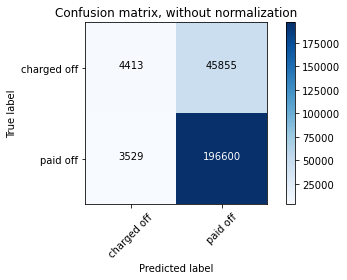

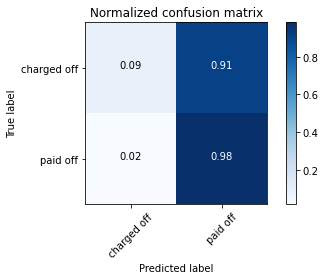

In [57]:
class_names=['charged off', 'paid off'] # name  of classes



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

30


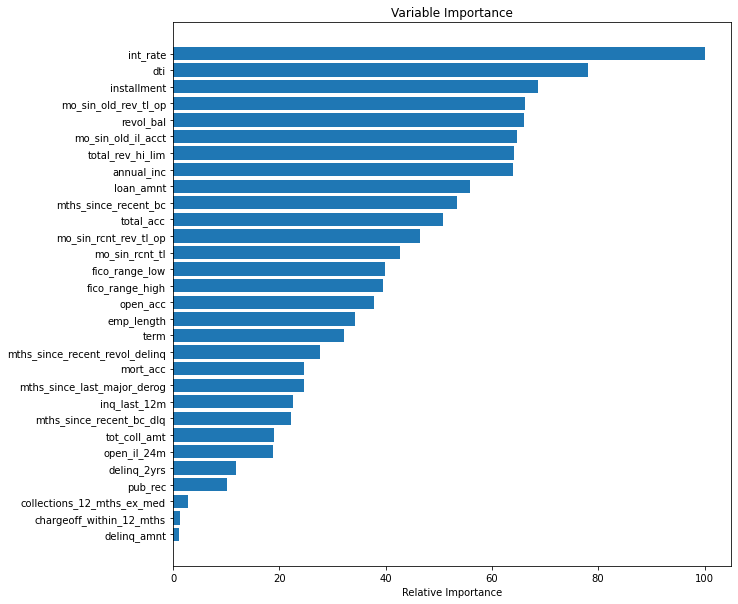

In [58]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### AdaBoost

In [59]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('AdaBoost: Accuracy=%.3f' % (ac))

print('AdaBoost: f1-score=%.3f' % (f1))

AdaBoost: Accuracy=0.802
AdaBoost: f1-score=0.735


Confusion matrix, without normalization
[[  3471  46797]
 [  2769 197360]]
Normalized confusion matrix
[[0.07 0.93]
 [0.01 0.99]]


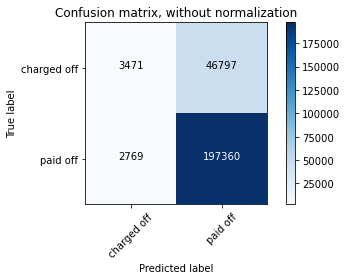

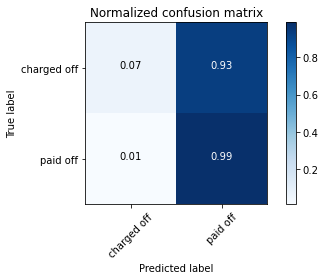

In [60]:
class_names=['charged off', 'paid off'] # name  of classes



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

30


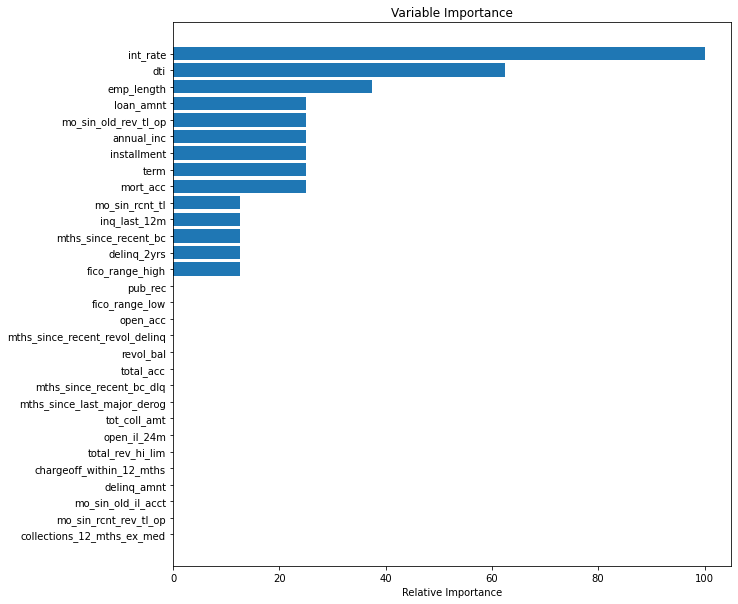

In [61]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Gradient Boost

In [62]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('GradientBoosting: Accuracy=%.3f' % (ac))

print('GradientBoosting: f1-score=%.3f' % (f1))

GradientBoosting: Accuracy=0.803
GradientBoosting: f1-score=0.737


Confusion matrix, without normalization
[[  3832  46436]
 [  2878 197251]]
Normalized confusion matrix
[[0.08 0.92]
 [0.01 0.99]]


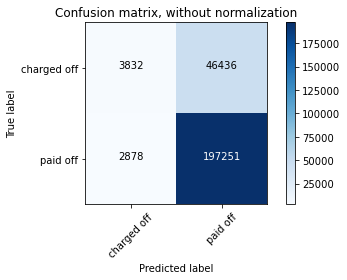

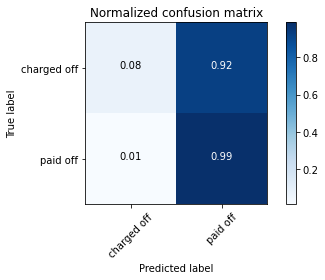

In [63]:
class_names=['charged off', 'paid off'] # name  of classes



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Just testing this way of estimating good hyperparams

In [80]:
#How do I know what is being measured in Precision/Recall/F-Score
def train_GB(est,max_depth,lr,splits,leaves,features):
    start = time.time()
    gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr,min_samples_split=splits,min_samples_leaf=leaves,max_features=features)
    gb_model = gb.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, pos_label='Charged Off', average='binary')
    end = time.time()
    print('Est: {} / Dep: {} / LR: {} / SplSiz: {} / LfSiz: {} / Feat: {} -- Prec: {} / Rec: {} / Acc: {} / F-Sc: {} -- Minutes: {}'.format(est, max_depth, lr, round(splits,3), round(leaves,3), features, round(precision, 3), round(recall, 3), round(fscore, 3), round((y_pred==y_test).sum()/len(y_pred),3), round((end-start)/60,1)))

In [65]:
start = time.time()
for n_est in [50,100,150,200]:
    for max_depth in [3,7,11,15]:
        for lr in [.01,.1,.5,1]:
            train_GB(n_est, max_depth, lr)
end = time.time()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Est: 50 / Depth: 3 / LR: 0.01 ---- Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0 / F-Score: 0.799
Est: 50 / Depth: 3 / LR: 0.1 ---- Precision: 0.573 / Recall: 0.049 / Accuracy: 0.09 / F-Score: 0.802
Est: 50 / Depth: 3 / LR: 0.5 ---- Precision: 0.568 / Recall: 0.1 / Accuracy: 0.17 / F-Score: 0.804
Est: 50 / Depth: 3 / LR: 1 ---- Precision: 0.547 / Recall: 0.116 / Accuracy: 0.192 / F-Score: 0.803


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Est: 50 / Depth: 7 / LR: 0.01 ---- Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0 / F-Score: 0.799
Est: 50 / Depth: 7 / LR: 0.1 ---- Precision: 0.585 / Recall: 0.089 / Accuracy: 0.154 / F-Score: 0.804
Est: 50 / Depth: 7 / LR: 0.5 ---- Precision: 0.529 / Recall: 0.128 / Accuracy: 0.207 / F-Score: 0.802
Est: 50 / Depth: 7 / LR: 1 ---- Precision: 0.47 / Recall: 0.152 / Accuracy: 0.23 / F-Score: 0.795


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Est: 50 / Depth: 11 / LR: 0.01 ---- Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0 / F-Score: 0.799
Est: 50 / Depth: 11 / LR: 0.1 ---- Precision: 0.56 / Recall: 0.109 / Accuracy: 0.182 / F-Score: 0.804
Est: 50 / Depth: 11 / LR: 0.5 ---- Precision: 0.428 / Recall: 0.165 / Accuracy: 0.238 / F-Score: 0.788
Est: 50 / Depth: 11 / LR: 1 ---- Precision: 0.375 / Recall: 0.203 / Accuracy: 0.263 / F-Score: 0.772
Est: 50 / Depth: 15 / LR: 0.01 ---- Precision: 0.833 / Recall: 0.0 / Accuracy: 0.0 / F-Score: 0.799
Est: 50 / Depth: 15 / LR: 0.1 ---- Precision: 0.511 / Recall: 0.127 / Accuracy: 0.203 / F-Score: 0.8
Est: 50 / Depth: 15 / LR: 0.5 ---- Precision: 0.356 / Recall: 0.211 / Accuracy: 0.265 / F-Score: 0.765
Est: 50 / Depth: 15 / LR: 1 ---- Precision: 0.321 / Recall: 0.246 / Accuracy: 0.278 / F-Score: 0.744


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Est: 100 / Depth: 3 / LR: 0.01 ---- Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0 / F-Score: 0.799
Est: 100 / Depth: 3 / LR: 0.1 ---- Precision: 0.571 / Recall: 0.076 / Accuracy: 0.135 / F-Score: 0.803
Est: 100 / Depth: 3 / LR: 0.5 ---- Precision: 0.568 / Recall: 0.106 / Accuracy: 0.179 / F-Score: 0.804
Est: 100 / Depth: 3 / LR: 1 ---- Precision: 0.548 / Recall: 0.12 / Accuracy: 0.196 / F-Score: 0.803


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Est: 100 / Depth: 7 / LR: 0.01 ---- Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0 / F-Score: 0.799
Est: 100 / Depth: 7 / LR: 0.1 ---- Precision: 0.58 / Recall: 0.104 / Accuracy: 0.176 / F-Score: 0.805
Est: 100 / Depth: 7 / LR: 0.5 ---- Precision: 0.509 / Recall: 0.135 / Accuracy: 0.213 / F-Score: 0.8
Est: 100 / Depth: 7 / LR: 1 ---- Precision: 0.449 / Recall: 0.164 / Accuracy: 0.241 / F-Score: 0.792
Est: 100 / Depth: 11 / LR: 0.01 ---- Precision: 0.737 / Recall: 0.003 / Accuracy: 0.006 / F-Score: 0.8
Est: 100 / Depth: 11 / LR: 0.1 ---- Precision: 0.547 / Recall: 0.121 / Accuracy: 0.198 / F-Score: 0.803
Est: 100 / Depth: 11 / LR: 0.5 ---- Precision: 0.405 / Recall: 0.179 / Accuracy: 0.248 / F-Score: 0.782
Est: 100 / Depth: 11 / LR: 1 ---- Precision: 0.354 / Recall: 0.225 / Accuracy: 0.275 / F-Score: 0.762
Est: 100 / Depth: 15 / LR: 0.01 ---- Precision: 0.628 / Recall: 0.013 / Accuracy: 0.025 / F-Score: 0.8
Est: 100 / Depth: 15 / LR: 0.1 ---- Precision: 0.503 / Recall: 0.136 / Accuracy: 0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Est: 150 / Depth: 3 / LR: 0.01 ---- Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0 / F-Score: 0.799
Est: 150 / Depth: 3 / LR: 0.1 ---- Precision: 0.574 / Recall: 0.085 / Accuracy: 0.148 / F-Score: 0.804
Est: 150 / Depth: 3 / LR: 0.5 ---- Precision: 0.565 / Recall: 0.109 / Accuracy: 0.183 / F-Score: 0.804
Est: 150 / Depth: 3 / LR: 1 ---- Precision: 0.542 / Recall: 0.124 / Accuracy: 0.202 / F-Score: 0.803
Est: 150 / Depth: 7 / LR: 0.01 ---- Precision: 0.661 / Recall: 0.008 / Accuracy: 0.015 / F-Score: 0.8
Est: 150 / Depth: 7 / LR: 0.1 ---- Precision: 0.577 / Recall: 0.11 / Accuracy: 0.185 / F-Score: 0.805
Est: 150 / Depth: 7 / LR: 0.5 ---- Precision: 0.495 / Recall: 0.141 / Accuracy: 0.219 / F-Score: 0.799
Est: 150 / Depth: 7 / LR: 1 ---- Precision: 0.431 / Recall: 0.175 / Accuracy: 0.249 / F-Score: 0.788
Est: 150 / Depth: 11 / LR: 0.01 ---- Precision: 0.632 / Recall: 0.023 / Accuracy: 0.044 / F-Score: 0.801
Est: 150 / Depth: 11 / LR: 0.1 ---- Precision: 0.542 / Recall: 0.126 / Accuracy: 0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Est: 200 / Depth: 3 / LR: 0.01 ---- Precision: 0.0 / Recall: 0.0 / Accuracy: 0.0 / F-Score: 0.799
Est: 200 / Depth: 3 / LR: 0.1 ---- Precision: 0.571 / Recall: 0.089 / Accuracy: 0.153 / F-Score: 0.804
Est: 200 / Depth: 3 / LR: 0.5 ---- Precision: 0.563 / Recall: 0.112 / Accuracy: 0.186 / F-Score: 0.804
Est: 200 / Depth: 3 / LR: 1 ---- Precision: 0.542 / Recall: 0.129 / Accuracy: 0.208 / F-Score: 0.803
Est: 200 / Depth: 7 / LR: 0.01 ---- Precision: 0.621 / Recall: 0.027 / Accuracy: 0.051 / F-Score: 0.801
Est: 200 / Depth: 7 / LR: 0.1 ---- Precision: 0.573 / Recall: 0.113 / Accuracy: 0.189 / F-Score: 0.805
Est: 200 / Depth: 7 / LR: 0.5 ---- Precision: 0.483 / Recall: 0.146 / Accuracy: 0.224 / F-Score: 0.797
Est: 200 / Depth: 7 / LR: 1 ---- Precision: 0.415 / Recall: 0.183 / Accuracy: 0.254 / F-Score: 0.784
Est: 200 / Depth: 11 / LR: 0.01 ---- Precision: 0.606 / Recall: 0.048 / Accuracy: 0.088 / F-Score: 0.803
Est: 200 / Depth: 11 / LR: 0.1 ---- Precision: 0.534 / Recall: 0.13 / Accuracy:

In [68]:
print('Run time in minutes: ', (end-start)/60)

Run time in minutes:  2907.2409455140432


In [ ]:
start = time.time()
for n_est in [32,64,100]:
    for max_depth in [8,16,32]:
        for lr in [.5,1]:
            for splits in [2,20,200,2000,20000]:
                for leaves in [1,10,100,1000,10000]:
                    for features in [1,20,40,60,X_train.shape[1]]:
                        train_GB(n_est, max_depth, lr,splits,leaves,features)
end = time.time()

Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 2 / LfSiz: 1 / Feat: 1 -- Prec: 0.52 / Rec: 0.085 / Acc: 0.146 / F-Sc: 0.801 -- Minutes: 0.4
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 2 / LfSiz: 1 / Feat: 20 -- Prec: 0.519 / Rec: 0.124 / Acc: 0.2 / F-Sc: 0.801 -- Minutes: 2.8
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 2 / LfSiz: 1 / Feat: 40 -- Prec: 0.514 / Rec: 0.123 / Acc: 0.199 / F-Sc: 0.801 -- Minutes: 5.2
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 2 / LfSiz: 1 / Feat: 60 -- Prec: 0.517 / Rec: 0.127 / Acc: 0.204 / F-Sc: 0.801 -- Minutes: 7.5
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 2 / LfSiz: 1 / Feat: 77 -- Prec: 0.516 / Rec: 0.128 / Acc: 0.205 / F-Sc: 0.801 -- Minutes: 10.1
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 2 / LfSiz: 10 / Feat: 1 -- Prec: 0.52 / Rec: 0.088 / Acc: 0.151 / F-Sc: 0.801 -- Minutes: 0.4
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 2 / LfSiz: 10 / Feat: 20 -- Prec: 0.529 / Rec: 0.126 / Acc: 0.203 / F-Sc: 0.802 -- Minutes: 2.9
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 2 / LfSiz: 10 / Feat: 40 -- Prec: 0.527 / 

Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 200 / LfSiz: 100 / Feat: 40 -- Prec: 0.534 / Rec: 0.125 / Acc: 0.203 / F-Sc: 0.802 -- Minutes: 5.7
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 200 / LfSiz: 100 / Feat: 60 -- Prec: 0.538 / Rec: 0.127 / Acc: 0.205 / F-Sc: 0.803 -- Minutes: 8.2
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 200 / LfSiz: 100 / Feat: 77 -- Prec: 0.537 / Rec: 0.129 / Acc: 0.208 / F-Sc: 0.803 -- Minutes: 10.5
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 200 / LfSiz: 1000 / Feat: 1 -- Prec: 0.528 / Rec: 0.094 / Acc: 0.159 / F-Sc: 0.801 -- Minutes: 0.3
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 200 / LfSiz: 1000 / Feat: 20 -- Prec: 0.544 / Rec: 0.118 / Acc: 0.193 / F-Sc: 0.803 -- Minutes: 2.9
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 200 / LfSiz: 1000 / Feat: 40 -- Prec: 0.548 / Rec: 0.124 / Acc: 0.202 / F-Sc: 0.804 -- Minutes: 5.6
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 200 / LfSiz: 1000 / Feat: 60 -- Prec: 0.544 / Rec: 0.119 / Acc: 0.196 / F-Sc: 0.803 -- Minutes: 8.1
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 200 / L

Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10000 / Feat: 40 -- Prec: 0.557 / Rec: 0.113 / Acc: 0.188 / F-Sc: 0.804 -- Minutes: 4.5
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10000 / Feat: 60 -- Prec: 0.557 / Rec: 0.115 / Acc: 0.191 / F-Sc: 0.804 -- Minutes: 6.6
Est: 32 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10000 / Feat: 77 -- Prec: 0.56 / Rec: 0.112 / Acc: 0.187 / F-Sc: 0.804 -- Minutes: 8.3
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 2 / LfSiz: 1 / Feat: 1 -- Prec: 0.471 / Rec: 0.129 / Acc: 0.203 / F-Sc: 0.796 -- Minutes: 0.4
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 2 / LfSiz: 1 / Feat: 20 -- Prec: 0.469 / Rec: 0.152 / Acc: 0.23 / F-Sc: 0.795 -- Minutes: 2.7
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 2 / LfSiz: 1 / Feat: 40 -- Prec: 0.466 / Rec: 0.153 / Acc: 0.23 / F-Sc: 0.795 -- Minutes: 5.2
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 2 / LfSiz: 1 / Feat: 60 -- Prec: 0.466 / Rec: 0.155 / Acc: 0.233 / F-Sc: 0.795 -- Minutes: 7.4
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 2 / LfSiz: 1 / Feat: 77 -- Pr

Est: 32 / Dep: 8 / LR: 1 / SplSiz: 200 / LfSiz: 10 / Feat: 77 -- Prec: 0.467 / Rec: 0.155 / Acc: 0.233 / F-Sc: 0.795 -- Minutes: 9.5
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 200 / LfSiz: 100 / Feat: 1 -- Prec: 0.477 / Rec: 0.131 / Acc: 0.205 / F-Sc: 0.797 -- Minutes: 0.3
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 200 / LfSiz: 100 / Feat: 20 -- Prec: 0.481 / Rec: 0.156 / Acc: 0.235 / F-Sc: 0.797 -- Minutes: 2.7
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 200 / LfSiz: 100 / Feat: 40 -- Prec: 0.474 / Rec: 0.158 / Acc: 0.237 / F-Sc: 0.796 -- Minutes: 5.1
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 200 / LfSiz: 100 / Feat: 60 -- Prec: 0.47 / Rec: 0.157 / Acc: 0.236 / F-Sc: 0.795 -- Minutes: 7.5
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 200 / LfSiz: 100 / Feat: 77 -- Prec: 0.472 / Rec: 0.16 / Acc: 0.238 / F-Sc: 0.795 -- Minutes: 9.4
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 200 / LfSiz: 1000 / Feat: 1 -- Prec: 0.465 / Rec: 0.125 / Acc: 0.197 / F-Sc: 0.795 -- Minutes: 0.3
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 200 / LfSiz: 1000 / Feat: 20 --

Est: 32 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10000 / Feat: 1 -- Prec: 0.486 / Rec: 0.107 / Acc: 0.176 / F-Sc: 0.798 -- Minutes: 0.2
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10000 / Feat: 20 -- Prec: 0.514 / Rec: 0.13 / Acc: 0.207 / F-Sc: 0.801 -- Minutes: 2.4
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10000 / Feat: 40 -- Prec: 0.526 / Rec: 0.127 / Acc: 0.204 / F-Sc: 0.802 -- Minutes: 4.5
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10000 / Feat: 60 -- Prec: 0.523 / Rec: 0.131 / Acc: 0.209 / F-Sc: 0.802 -- Minutes: 6.6
Est: 32 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10000 / Feat: 77 -- Prec: 0.522 / Rec: 0.133 / Acc: 0.212 / F-Sc: 0.802 -- Minutes: 8.4
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 2 / LfSiz: 1 / Feat: 1 -- Prec: 0.397 / Rec: 0.149 / Acc: 0.217 / F-Sc: 0.784 -- Minutes: 4.7
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 2 / LfSiz: 1 / Feat: 20 -- Prec: 0.355 / Rec: 0.206 / Acc: 0.26 / F-Sc: 0.765 -- Minutes: 11.5
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 2 / LfSiz

Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 200 / LfSiz: 10 / Feat: 20 -- Prec: 0.441 / Rec: 0.173 / Acc: 0.249 / F-Sc: 0.79 -- Minutes: 5.8
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 200 / LfSiz: 10 / Feat: 40 -- Prec: 0.433 / Rec: 0.175 / Acc: 0.249 / F-Sc: 0.788 -- Minutes: 10.4
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 200 / LfSiz: 10 / Feat: 60 -- Prec: 0.434 / Rec: 0.178 / Acc: 0.253 / F-Sc: 0.788 -- Minutes: 14.8
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 200 / LfSiz: 10 / Feat: 77 -- Prec: 0.426 / Rec: 0.179 / Acc: 0.252 / F-Sc: 0.787 -- Minutes: 18.8
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 200 / LfSiz: 100 / Feat: 1 -- Prec: 0.495 / Rec: 0.115 / Acc: 0.187 / F-Sc: 0.799 -- Minutes: 0.6
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 200 / LfSiz: 100 / Feat: 20 -- Prec: 0.455 / Rec: 0.17 / Acc: 0.248 / F-Sc: 0.792 -- Minutes: 5.7
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 200 / LfSiz: 100 / Feat: 40 -- Prec: 0.457 / Rec: 0.173 / Acc: 0.251 / F-Sc: 0.793 -- Minutes: 10.2
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 200 / 

Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1000 / Feat: 20 -- Prec: 0.547 / Rec: 0.119 / Acc: 0.195 / F-Sc: 0.803 -- Minutes: 3.8
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1000 / Feat: 40 -- Prec: 0.553 / Rec: 0.117 / Acc: 0.194 / F-Sc: 0.804 -- Minutes: 7.1
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1000 / Feat: 60 -- Prec: 0.549 / Rec: 0.121 / Acc: 0.198 / F-Sc: 0.804 -- Minutes: 10.6
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1000 / Feat: 77 -- Prec: 0.553 / Rec: 0.121 / Acc: 0.199 / F-Sc: 0.804 -- Minutes: 13.5
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10000 / Feat: 1 -- Prec: 0.515 / Rec: 0.046 / Acc: 0.084 / F-Sc: 0.8 -- Minutes: 0.2
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10000 / Feat: 20 -- Prec: 0.558 / Rec: 0.11 / Acc: 0.184 / F-Sc: 0.804 -- Minutes: 3.1
Est: 32 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10000 / Feat: 40 -- Prec: 0.554 / Rec: 0.113 / Acc: 0.188 / F-Sc: 0.804 -- Minutes: 5.9
Est: 32 / Dep: 16 /

Est: 32 / Dep: 16 / LR: 1 / SplSiz: 200 / LfSiz: 1 / Feat: 40 -- Prec: 0.361 / Rec: 0.224 / Acc: 0.276 / F-Sc: 0.765 -- Minutes: 11.1
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 200 / LfSiz: 1 / Feat: 60 -- Prec: 0.359 / Rec: 0.221 / Acc: 0.273 / F-Sc: 0.764 -- Minutes: 17.0
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 200 / LfSiz: 1 / Feat: 77 -- Prec: 0.351 / Rec: 0.227 / Acc: 0.276 / F-Sc: 0.761 -- Minutes: 22.7
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 200 / LfSiz: 10 / Feat: 1 -- Prec: 0.396 / Rec: 0.173 / Acc: 0.241 / F-Sc: 0.781 -- Minutes: 1.3
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 200 / LfSiz: 10 / Feat: 20 -- Prec: 0.37 / Rec: 0.225 / Acc: 0.28 / F-Sc: 0.767 -- Minutes: 7.1
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 200 / LfSiz: 10 / Feat: 40 -- Prec: 0.361 / Rec: 0.229 / Acc: 0.28 / F-Sc: 0.764 -- Minutes: 12.6
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 200 / LfSiz: 10 / Feat: 60 -- Prec: 0.358 / Rec: 0.232 / Acc: 0.282 / F-Sc: 0.762 -- Minutes: 18.1
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 200 / LfSiz: 10 / Feat: 77 -

Est: 32 / Dep: 16 / LR: 1 / SplSiz: 20000 / LfSiz: 100 / Feat: 60 -- Prec: 0.505 / Rec: 0.147 / Acc: 0.228 / F-Sc: 0.8 -- Minutes: 11.5
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 20000 / LfSiz: 100 / Feat: 77 -- Prec: 0.501 / Rec: 0.146 / Acc: 0.226 / F-Sc: 0.799 -- Minutes: 14.8
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 20000 / LfSiz: 1000 / Feat: 1 -- Prec: 0.476 / Rec: 0.135 / Acc: 0.21 / F-Sc: 0.797 -- Minutes: 0.3
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 20000 / LfSiz: 1000 / Feat: 20 -- Prec: 0.511 / Rec: 0.145 / Acc: 0.226 / F-Sc: 0.8 -- Minutes: 3.9
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 20000 / LfSiz: 1000 / Feat: 40 -- Prec: 0.5 / Rec: 0.141 / Acc: 0.221 / F-Sc: 0.799 -- Minutes: 7.5
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 20000 / LfSiz: 1000 / Feat: 60 -- Prec: 0.507 / Rec: 0.145 / Acc: 0.225 / F-Sc: 0.8 -- Minutes: 11.2
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 20000 / LfSiz: 1000 / Feat: 77 -- Prec: 0.51 / Rec: 0.146 / Acc: 0.227 / F-Sc: 0.8 -- Minutes: 14.1
Est: 32 / Dep: 16 / LR: 1 / SplSiz: 20000 / L

Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 20 / LfSiz: 10000 / Feat: 77 -- Prec: 0.56 / Rec: 0.116 / Acc: 0.192 / F-Sc: 0.804 -- Minutes: 11.8
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 200 / LfSiz: 1 / Feat: 1 -- Prec: 0.381 / Rec: 0.188 / Acc: 0.252 / F-Sc: 0.776 -- Minutes: 5.3
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 200 / LfSiz: 1 / Feat: 20 -- Prec: 0.382 / Rec: 0.207 / Acc: 0.269 / F-Sc: 0.773 -- Minutes: 13.2
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 200 / LfSiz: 1 / Feat: 40 -- Prec: 0.382 / Rec: 0.208 / Acc: 0.269 / F-Sc: 0.773 -- Minutes: 21.0
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 200 / LfSiz: 1 / Feat: 60 -- Prec: 0.377 / Rec: 0.206 / Acc: 0.266 / F-Sc: 0.772 -- Minutes: 29.0
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 200 / LfSiz: 1 / Feat: 77 -- Prec: 0.382 / Rec: 0.207 / Acc: 0.269 / F-Sc: 0.774 -- Minutes: 35.6
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 200 / LfSiz: 10 / Feat: 1 -- Prec: 0.416 / Rec: 0.165 / Acc: 0.237 / F-Sc: 0.786 -- Minutes: 2.6
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 200 / LfSiz

Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10 / Feat: 77 -- Prec: 0.538 / Rec: 0.129 / Acc: 0.208 / F-Sc: 0.803 -- Minutes: 20.0
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 20000 / LfSiz: 100 / Feat: 1 -- Prec: 0.523 / Rec: 0.094 / Acc: 0.159 / F-Sc: 0.801 -- Minutes: 0.5
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 20000 / LfSiz: 100 / Feat: 20 -- Prec: 0.545 / Rec: 0.125 / Acc: 0.203 / F-Sc: 0.803 -- Minutes: 4.9
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 20000 / LfSiz: 100 / Feat: 40 -- Prec: 0.545 / Rec: 0.125 / Acc: 0.204 / F-Sc: 0.803 -- Minutes: 9.8
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 20000 / LfSiz: 100 / Feat: 60 -- Prec: 0.54 / Rec: 0.124 / Acc: 0.201 / F-Sc: 0.803 -- Minutes: 14.9
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 20000 / LfSiz: 100 / Feat: 77 -- Prec: 0.542 / Rec: 0.126 / Acc: 0.205 / F-Sc: 0.803 -- Minutes: 20.9
Est: 32 / Dep: 32 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1000 / Feat: 1 -- Prec: 0.497 / Rec: 0.084 / Acc: 0.144 / F-Sc: 0.799 -- Minutes: 0.4
Est: 32 / Dep: 32 / LR: 0.5

Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20 / LfSiz: 10000 / Feat: 1 -- Prec: 0.486 / Rec: 0.098 / Acc: 0.163 / F-Sc: 0.798 -- Minutes: 0.2
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20 / LfSiz: 10000 / Feat: 20 -- Prec: 0.513 / Rec: 0.131 / Acc: 0.208 / F-Sc: 0.801 -- Minutes: 3.2
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20 / LfSiz: 10000 / Feat: 40 -- Prec: 0.513 / Rec: 0.133 / Acc: 0.211 / F-Sc: 0.801 -- Minutes: 6.4
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20 / LfSiz: 10000 / Feat: 60 -- Prec: 0.517 / Rec: 0.138 / Acc: 0.218 / F-Sc: 0.801 -- Minutes: 9.1
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20 / LfSiz: 10000 / Feat: 77 -- Prec: 0.518 / Rec: 0.136 / Acc: 0.215 / F-Sc: 0.801 -- Minutes: 11.7
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 200 / LfSiz: 1 / Feat: 1 -- Prec: 0.317 / Rec: 0.251 / Acc: 0.28 / F-Sc: 0.741 -- Minutes: 5.3
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 200 / LfSiz: 1 / Feat: 20 -- Prec: 0.33 / Rec: 0.254 / Acc: 0.287 / F-Sc: 0.747 -- Minutes: 12.8
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 200 / LfSiz: 1 / Fea

Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20000 / LfSiz: 10 / Feat: 20 -- Prec: 0.465 / Rec: 0.156 / Acc: 0.234 / F-Sc: 0.795 -- Minutes: 6.4
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20000 / LfSiz: 10 / Feat: 40 -- Prec: 0.474 / Rec: 0.157 / Acc: 0.236 / F-Sc: 0.796 -- Minutes: 12.6
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20000 / LfSiz: 10 / Feat: 60 -- Prec: 0.472 / Rec: 0.158 / Acc: 0.237 / F-Sc: 0.795 -- Minutes: 18.8
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20000 / LfSiz: 10 / Feat: 77 -- Prec: 0.469 / Rec: 0.16 / Acc: 0.239 / F-Sc: 0.795 -- Minutes: 23.5
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20000 / LfSiz: 100 / Feat: 1 -- Prec: 0.479 / Rec: 0.131 / Acc: 0.205 / F-Sc: 0.797 -- Minutes: 0.5
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20000 / LfSiz: 100 / Feat: 20 -- Prec: 0.483 / Rec: 0.158 / Acc: 0.238 / F-Sc: 0.797 -- Minutes: 5.9
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20000 / LfSiz: 100 / Feat: 40 -- Prec: 0.484 / Rec: 0.162 / Acc: 0.242 / F-Sc: 0.797 -- Minutes: 11.2
Est: 32 / Dep: 32 / LR: 1 / SplSiz: 20000 /

Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20 / LfSiz: 1000 / Feat: 40 -- Prec: 0.542 / Rec: 0.13 / Acc: 0.21 / F-Sc: 0.803 -- Minutes: 10.3
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20 / LfSiz: 1000 / Feat: 60 -- Prec: 0.538 / Rec: 0.132 / Acc: 0.211 / F-Sc: 0.803 -- Minutes: 15.4
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20 / LfSiz: 1000 / Feat: 77 -- Prec: 0.545 / Rec: 0.132 / Acc: 0.213 / F-Sc: 0.804 -- Minutes: 19.5
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20 / LfSiz: 10000 / Feat: 1 -- Prec: 0.516 / Rec: 0.096 / Acc: 0.162 / F-Sc: 0.8 -- Minutes: 0.4
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20 / LfSiz: 10000 / Feat: 20 -- Prec: 0.561 / Rec: 0.115 / Acc: 0.191 / F-Sc: 0.804 -- Minutes: 5.0
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20 / LfSiz: 10000 / Feat: 40 -- Prec: 0.555 / Rec: 0.119 / Acc: 0.196 / F-Sc: 0.804 -- Minutes: 9.3
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20 / LfSiz: 10000 / Feat: 60 -- Prec: 0.56 / Rec: 0.121 / Acc: 0.199 / F-Sc: 0.804 -- Minutes: 13.9
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20 / LfSi

Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1 / Feat: 60 -- Prec: 0.552 / Rec: 0.119 / Acc: 0.196 / F-Sc: 0.804 -- Minutes: 15.0
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1 / Feat: 77 -- Prec: 0.554 / Rec: 0.121 / Acc: 0.199 / F-Sc: 0.804 -- Minutes: 19.4
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10 / Feat: 1 -- Prec: 0.532 / Rec: 0.1 / Acc: 0.169 / F-Sc: 0.802 -- Minutes: 0.7
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10 / Feat: 20 -- Prec: 0.555 / Rec: 0.12 / Acc: 0.197 / F-Sc: 0.804 -- Minutes: 5.5
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10 / Feat: 40 -- Prec: 0.553 / Rec: 0.12 / Acc: 0.198 / F-Sc: 0.804 -- Minutes: 10.4
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10 / Feat: 60 -- Prec: 0.551 / Rec: 0.122 / Acc: 0.199 / F-Sc: 0.804 -- Minutes: 15.2
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20000 / LfSiz: 10 / Feat: 77 -- Prec: 0.549 / Rec: 0.121 / Acc: 0.199 / F-Sc: 0.804 -- Minutes: 18.9
Est: 64 / Dep: 8 / LR: 0.5 / SplSiz: 20000 

Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20 / LfSiz: 1000 / Feat: 1 -- Prec: 0.483 / Rec: 0.134 / Acc: 0.209 / F-Sc: 0.797 -- Minutes: 0.5
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20 / LfSiz: 1000 / Feat: 20 -- Prec: 0.492 / Rec: 0.158 / Acc: 0.239 / F-Sc: 0.798 -- Minutes: 5.4
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20 / LfSiz: 1000 / Feat: 40 -- Prec: 0.488 / Rec: 0.156 / Acc: 0.237 / F-Sc: 0.798 -- Minutes: 10.2
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20 / LfSiz: 1000 / Feat: 60 -- Prec: 0.49 / Rec: 0.159 / Acc: 0.24 / F-Sc: 0.798 -- Minutes: 15.3
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20 / LfSiz: 1000 / Feat: 77 -- Prec: 0.487 / Rec: 0.159 / Acc: 0.24 / F-Sc: 0.798 -- Minutes: 19.3
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20 / LfSiz: 10000 / Feat: 1 -- Prec: 0.503 / Rec: 0.113 / Acc: 0.185 / F-Sc: 0.799 -- Minutes: 0.4
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20 / LfSiz: 10000 / Feat: 20 -- Prec: 0.512 / Rec: 0.14 / Acc: 0.219 / F-Sc: 0.801 -- Minutes: 4.8
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20 / LfSiz: 10000 / Feat: 40

Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 1 / Feat: 20 -- Prec: 0.507 / Rec: 0.141 / Acc: 0.22 / F-Sc: 0.8 -- Minutes: 5.3
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 1 / Feat: 40 -- Prec: 0.508 / Rec: 0.142 / Acc: 0.222 / F-Sc: 0.8 -- Minutes: 10.1
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 1 / Feat: 60 -- Prec: 0.508 / Rec: 0.138 / Acc: 0.217 / F-Sc: 0.8 -- Minutes: 15.1
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 1 / Feat: 77 -- Prec: 0.51 / Rec: 0.139 / Acc: 0.219 / F-Sc: 0.8 -- Minutes: 19.4
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10 / Feat: 1 -- Prec: 0.488 / Rec: 0.133 / Acc: 0.21 / F-Sc: 0.798 -- Minutes: 0.6
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10 / Feat: 20 -- Prec: 0.503 / Rec: 0.14 / Acc: 0.22 / F-Sc: 0.8 -- Minutes: 5.4
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10 / Feat: 40 -- Prec: 0.516 / Rec: 0.142 / Acc: 0.223 / F-Sc: 0.801 -- Minutes: 9.9
Est: 64 / Dep: 8 / LR: 1 / SplSiz: 20000 / LfSiz: 10 / Feat: 60 -- Prec:

Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20 / LfSiz: 100 / Feat: 40 -- Prec: 0.427 / Rec: 0.184 / Acc: 0.257 / F-Sc: 0.787 -- Minutes: 21.2
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20 / LfSiz: 100 / Feat: 60 -- Prec: 0.428 / Rec: 0.186 / Acc: 0.259 / F-Sc: 0.787 -- Minutes: 30.7
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20 / LfSiz: 100 / Feat: 77 -- Prec: 0.428 / Rec: 0.184 / Acc: 0.258 / F-Sc: 0.787 -- Minutes: 38.6
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20 / LfSiz: 1000 / Feat: 1 -- Prec: 0.531 / Rec: 0.101 / Acc: 0.169 / F-Sc: 0.802 -- Minutes: 0.7
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20 / LfSiz: 1000 / Feat: 20 -- Prec: 0.508 / Rec: 0.147 / Acc: 0.228 / F-Sc: 0.8 -- Minutes: 9.9
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20 / LfSiz: 1000 / Feat: 40 -- Prec: 0.504 / Rec: 0.149 / Acc: 0.23 / F-Sc: 0.8 -- Minutes: 18.8
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20 / LfSiz: 1000 / Feat: 60 -- Prec: 0.506 / Rec: 0.152 / Acc: 0.233 / F-Sc: 0.8 -- Minutes: 31.8
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20 / LfSi

Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 2000 / LfSiz: 10000 / Feat: 40 -- Prec: 0.552 / Rec: 0.123 / Acc: 0.201 / F-Sc: 0.804 -- Minutes: 14.0
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 2000 / LfSiz: 10000 / Feat: 60 -- Prec: 0.55 / Rec: 0.124 / Acc: 0.202 / F-Sc: 0.804 -- Minutes: 20.9
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 2000 / LfSiz: 10000 / Feat: 77 -- Prec: 0.555 / Rec: 0.126 / Acc: 0.205 / F-Sc: 0.804 -- Minutes: 26.1
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1 / Feat: 1 -- Prec: 0.527 / Rec: 0.116 / Acc: 0.19 / F-Sc: 0.802 -- Minutes: 1.2
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1 / Feat: 20 -- Prec: 0.534 / Rec: 0.133 / Acc: 0.213 / F-Sc: 0.803 -- Minutes: 9.5
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1 / Feat: 40 -- Prec: 0.536 / Rec: 0.13 / Acc: 0.21 / F-Sc: 0.803 -- Minutes: 18.1
Est: 64 / Dep: 16 / LR: 0.5 / SplSiz: 20000 / LfSiz: 1 / Feat: 60 -- Prec: 0.535 / Rec: 0.131 / Acc: 0.211 / F-Sc: 0.803 -- Minutes: 26.7
Est: 64 / Dep: 16 / LR: 0.5 / Sp

Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20 / LfSiz: 10 / Feat: 60 -- Prec: 0.325 / Rec: 0.253 / Acc: 0.285 / F-Sc: 0.744 -- Minutes: 33.5
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20 / LfSiz: 10 / Feat: 77 -- Prec: 0.323 / Rec: 0.248 / Acc: 0.281 / F-Sc: 0.745 -- Minutes: 41.4
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20 / LfSiz: 100 / Feat: 1 -- Prec: 0.421 / Rec: 0.181 / Acc: 0.253 / F-Sc: 0.786 -- Minutes: 1.3
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20 / LfSiz: 100 / Feat: 20 -- Prec: 0.349 / Rec: 0.245 / Acc: 0.288 / F-Sc: 0.757 -- Minutes: 11.4
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20 / LfSiz: 100 / Feat: 40 -- Prec: 0.343 / Rec: 0.249 / Acc: 0.288 / F-Sc: 0.753 -- Minutes: 21.0
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20 / LfSiz: 100 / Feat: 60 -- Prec: 0.341 / Rec: 0.252 / Acc: 0.29 / F-Sc: 0.752 -- Minutes: 30.2
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20 / LfSiz: 100 / Feat: 77 -- Prec: 0.34 / Rec: 0.252 / Acc: 0.29 / F-Sc: 0.752 -- Minutes: 38.8
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20 / LfSiz: 1000 / Feat: 1

Est: 64 / Dep: 16 / LR: 1 / SplSiz: 2000 / LfSiz: 1000 / Feat: 77 -- Prec: 0.412 / Rec: 0.194 / Acc: 0.264 / F-Sc: 0.783 -- Minutes: 34.5
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 2000 / LfSiz: 10000 / Feat: 1 -- Prec: 0.511 / Rec: 0.102 / Acc: 0.171 / F-Sc: 0.8 -- Minutes: 0.4
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 2000 / LfSiz: 10000 / Feat: 20 -- Prec: 0.506 / Rec: 0.143 / Acc: 0.223 / F-Sc: 0.8 -- Minutes: 6.6
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 2000 / LfSiz: 10000 / Feat: 40 -- Prec: 0.512 / Rec: 0.146 / Acc: 0.228 / F-Sc: 0.801 -- Minutes: 12.6
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 2000 / LfSiz: 10000 / Feat: 60 -- Prec: 0.503 / Rec: 0.148 / Acc: 0.229 / F-Sc: 0.8 -- Minutes: 18.6
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 2000 / LfSiz: 10000 / Feat: 77 -- Prec: 0.506 / Rec: 0.149 / Acc: 0.23 / F-Sc: 0.8 -- Minutes: 23.8
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20000 / LfSiz: 1 / Feat: 1 -- Prec: 0.479 / Rec: 0.147 / Acc: 0.225 / F-Sc: 0.797 -- Minutes: 1.1
Est: 64 / Dep: 16 / LR: 1 / SplSiz: 20000 / L

### All kinds of hyperparams

In [ ]:
# start = time.time()
# gb = GradientBoostingClassifer()
# param = {
#     'n_estimators': [100,200],
#     'max_depth': [16, 32],
#     'learning_rate': [.5, 1],
#     'min_samples_split': [.1,.55,1],
#     'min_samples_leaf': [.1,.3,.5]
# }

# gs = GridSearchCV(gb,param,cv=5,n_jobs=-1)
# cv_fit = gs.fit(X_train, y_train)
# pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score',ascending=False)(0:5)
# end = time.time()

In [ ]:
# print('Run time in minutes: ', (end-start)/60)